In [10]:
import matplotlib.colors as colors
# %matplotlib qt  # or %matplotlib tk
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import gsw
import math
import scipy.io
import cmocean 
import sys
sys.path.insert(1, '/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis')
from functions_MSM74 import *
import fonctions as f
import matplotlib.ticker as ticker
import netCDF4 as nc
import cartopy.crs as ccrs
import gsw
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cmocean
import numpy as np
from scipy.signal import find_peaks
from matplotlib.colors import ListedColormap
from scipy.ndimage import label
import seaborn as sns
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patheffects as path_effects


In [40]:
def plot_coords_eddies(eddy_lons, eddy_lats, other_lons, other_lats, bathymetry, title='Eddy Locations', extent=[-70, -25, 50, 70], ax=None):
    bathymetry_data = xr.open_dataset(bathymetry)

    # Extract relevant variables (longitude, latitude, depth)
    bath_lon = bathymetry_data['lon']
    bath_lat = bathymetry_data['lat']
    bath_depth = bathymetry_data['topo']

    # Subset data to region of interest
    lon_min, lon_max, lat_min, lat_max = extent
    lon_subset = bath_lon.sel(lon=slice(lon_min, lon_max))
    lat_subset = bath_lat.sel(lat=slice(lat_min, lat_max))
    depth_subset = bath_depth.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

    # Generate distinct colors for each eddy using seaborn
    num_eddies = len(eddy_lons)
    eddy_colors = sns.color_palette("husl", num_eddies)  # Distinct colors

    # Create figure and axis if not passed
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot bathymetric relief
    c = ax.contourf(lon_subset, lat_subset, depth_subset, transform=ccrs.PlateCarree(), levels=20, cmap='Greys', zorder=0)

    # Set map extent and other features
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    gridlines = ax.gridlines(draw_labels=True)
    gridlines.xlabels_top = False  # Disable top x-axis labels
    gridlines.ylabels_right = False  

    # Plot eddies
    for i, (lon_arr, lat_arr) in enumerate(zip(eddy_lons, eddy_lats)):
        ax.scatter(lon_arr, lat_arr, color=eddy_colors[i], s=15, alpha=0.7, label=f'Eddy {i+1}', zorder=10)

    # Plot other locations
    other_lons = np.concatenate(other_lons)
    other_lats = np.concatenate(other_lats)
    ax.scatter(other_lons, other_lats, color='black', s=8, edgecolor='white', alpha=0.7, transform=ccrs.PlateCarree(), label='Other Locations')
    ax.yaxis.set_tick_params(labelright=False)
    ax.set_title(title)

    # Optional: Add color bar for bathymetry
    plt.colorbar(c, ax=ax, orientation='vertical', label='Depth (m)',shrink=0.3, pad=0.1)

    plt.show()
  

def extract_eddy_data_anom(temp_anomaly, temperature, salinity, density, xs, ind_Z, eddy_center, a, b, cruise="", section_num = "", e=0, sub_section=0):
    X, Z = np.meshgrid(xs, -1*ind_Z)
    x0, z0 = eddy_center

    # if cruise == "MSM40" and section_num == 1 and e==1:
    #     temp_eddy = np.full(temperature.shape, np.nan)
    #     sal_eddy = np.full(salinity.shape, np.nan)
    #     dens_eddy = np.full(density.shape, np.nan)
    #     zs_eddy = np.full(Z.shape, np.nan)

    #     # Fill first 350 rows at index 5 in axis 1 with the values from temperatures
    #     temp_eddy[:350, 5] = temperature[:350, 5]
    #     sal_eddy[:350, 5] = salinity[:350, 5]
    #     dens_eddy[:350, 5] = density[:350, 5]
    #     zs_eddy[:350, 5] = Z[:350, 5]

    #     # Create the second array as a copy of temperatures
    #     temp_other = temperature.copy()
    #     sal_other = salinity.copy()
    #     dens_other = density.copy()
    #     zs_other = Z.copy()

    #     # Set first 350 rows at index 5 in axis 1 to NaN
    #     temp_other[:350, 5] = np.nan
    #     sal_other[:350, 5] = np.nan
    #     dens_other[:350, 5] = np.nan
    #     zs_other[:350, 5] = np.nan

    #     # Now, array1 and array2 satisfy your conditions

    #     return (
    #     temp_eddy, temp_eddy.flatten(), sal_eddy.flatten(), dens_eddy.flatten(), zs_eddy.flatten(),
    #     temp_other.flatten(), sal_other.flatten(), dens_other.flatten(), zs_other.flatten()
    # )

    if cruise == "MSM40" and section_num == 1 and e == 1:
        print("EXTRACTING ELLIPTICAL DATA")
        return extract_eddy_data_ellip(xs, ind_Z, temperature, salinity, density, eddy_center, a, b)
    if cruise == "MSM40" and section_num == 3 and e == 2:
        print("EXTRACTING ELLIPTICAL DATA")
        return extract_eddy_data_ellip(xs, ind_Z, temperature, salinity, density, eddy_center, a, b)
    
    if cruise == "MSM40" and ((section_num == 5 and sub_section == 1 and (e == 2 or e==3)) or (section_num == 5 and sub_section == 2 and (e==2 or e==3 or e==4))):
        print("EXTRACTING ELLIPTICAL DATA")
        return extract_eddy_data_ellip(xs, ind_Z, temperature, salinity, density, eddy_center, a, b)
    
    if cruise == "MSM40" and section_num == 7 and sub_section == 2 and (e == 2 or e==3 or e ==4):
        print("EXTRACTING ELLIPTICAL DATA")
        return extract_eddy_data_ellip(xs, ind_Z, temperature, salinity, density, eddy_center, a, b)
    
    if cruise == "MSM74" and section_num == 2 and e==2:
        print("EXTRACTING ELLIPTICAL DATA")
        return extract_eddy_data_ellip(xs, ind_Z, temperature, salinity, density, eddy_center, a, b)
    # Initial ellipsoid mask for eddy range
    ellipsoid_mask = ((X - x0)**2 / a**2 + (Z - z0)**2 / b**2) <= 1

    # Extract anomaly values within the initial eddy range
    temp_anomaly_eddy = np.where(ellipsoid_mask, temp_anomaly, np.nan)
  
    # Find the maximum anomaly value and its location
    max_anomaly = temp_anomaly_eddy[np.unravel_index(np.nanargmax(np.abs(temp_anomaly_eddy)), temp_anomaly_eddy.shape)]
    # max_anomaly = np.nanmax(temp_anomaly_eddy)

    # Create a binary mask for regions above 50% of the peak anomaly
    if max_anomaly < 0:
        eddy_mask = ellipsoid_mask & (temp_anomaly <= (0.25 * max_anomaly))
    else:
        eddy_mask = ellipsoid_mask & (temp_anomaly >= (0.25 * max_anomaly))

    # Extract eddy properties based on refined eddy mask
    temp_eddy = np.where(eddy_mask, temperature, np.nan)
    sal_eddy = np.where(eddy_mask, salinity, np.nan)
    dens_eddy = np.where(eddy_mask, density, np.nan)
    zs_eddy = np.where(eddy_mask, Z, np.nan)
    
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipsoid_x = x0 + a * np.cos(theta)
    ellipsoid_z = z0 + b * np.sin(theta)
    
    # Ensure the ellipsoid is within the depth bounds
    # Extract non-eddy properties
    temp_other = np.where(~eddy_mask, temperature, np.nan)
    sal_other = np.where(~eddy_mask, salinity, np.nan)
    dens_other = np.where(~eddy_mask, density, np.nan)
    zs_other = np.where(~eddy_mask, Z, np.nan)
    
    return (
        temp_eddy, temp_eddy.flatten(), sal_eddy.flatten(), dens_eddy.flatten(), zs_eddy.flatten(),
        temp_other.flatten(), sal_other.flatten(), dens_other.flatten(), zs_other.flatten()
    )
def extract_eddy_data_ellip(xs, zs, temperature, salinity, density, eddy_center, a, b):
    X, Z = np.meshgrid(xs, -1*zs)
    x0, z0 = eddy_center
    ellipsoid_mask = ((X - x0)**2 / a**2 + (Z - z0)**2 / b**2) <= 1
    temp_eddy = np.where(ellipsoid_mask, temperature, np.nan)
    sal_eddy = np.where(ellipsoid_mask, salinity, np.nan)
    dens_eddy = np.where(ellipsoid_mask, density, np.nan)
    zs_eddy = np.where(ellipsoid_mask, Z, np.nan)

    temp_other = np.where(~ellipsoid_mask, temperature, np.nan)
    sal_other = np.where(~ellipsoid_mask, salinity, np.nan)
    dens_other = np.where(~ellipsoid_mask, density, np.nan)
    zs_other = np.where(~ellipsoid_mask, Z, np.nan)
    
    return temp_eddy, temp_eddy.flatten(), sal_eddy.flatten(), dens_eddy.flatten(), zs_eddy.flatten(), temp_other.flatten(), sal_other.flatten(), dens_other.flatten(), zs_other.flatten()


def create_ref_profile(var_grid, distance, lon, lat, x_min, x_max):
    sel_idxs = np.where((distance < x_max) & (distance > x_min))
    lons = lon[sel_idxs].squeeze()
    lats = lat[sel_idxs].squeeze()
    ref_profile = var_grid[:, sel_idxs].squeeze()
    # plt.contourf(ref_profile)
    # plt.ylim(0, 300)
    # plt.gca().invert_yaxis()
    
    return np.mean(ref_profile, axis=1), np.mean(lons), np.mean(lats)

def get_eddies(section_num, cruise, sub_section=None):
    if cruise == "MSM74":
        if section_num == 2:
            eddies = {1: (50, 220, 20, 120), 2: (369, 120, 20, 90)}
            return eddies
        if section_num == 3:
            eddies = {1: (230, 230, 90, 210)}
            return eddies
        if section_num == 4:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 5:
            eddies = {1: (80, 120, 8, 50), 2: (165, 115, 40, 60)}
            return eddies
        if section_num == 6:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 7:
            eddies = {1: (115, 280, 10, 150), 2: (200, 100, 10, 60), 3: (268, 190, 10, 100)}
            return eddies
    if cruise == "MSM40":
        if section_num == 1:
            eddies = {1: (162, 60, 12, 60), 2: (400, 70, 70, 180)}
            return eddies
        if section_num == 2:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 3:
            eddies = {1: (170, 70, 30, 50), 2: (375, 45, 9, 25), 3: (460, 30, 15, 35)}
            return eddies
        if section_num == 4:
            eddies = {1: (45, 125, 25, 125), 2: (120, 125, 16, 125), 3: (250, 130, 30, 120)}
            return eddies
        if section_num == 5:
            if sub_section == 1:
                eddies = {1: (65, 115, 45, 150),  2: (250, 145, 10, 115), 3: (315, 75, 9, 49), 4: (410, 150, 50, 140)} 
                return eddies
            if sub_section == 2:
                eddies = {1: (78, 50, 16, 40), 2: (125, 45, 8, 35), 3: (165, 45, 9, 35),  4: (215, 45, 14, 35), 5: (275, 40, 20, 90)}
                return eddies
        if section_num == 6:
            print(f"No eddies in {cruise} section {section_num}")
            return None
        if section_num == 7:
            if sub_section == 3:
                eddies = {1: (75, 75, 25, 100), 2: (137, 70, 10, 45), 3: (272, 120, 25,90)}
            if sub_section == 2:
                eddies = {1: (25, 65, 14, 20), 2: (180, 90, 12, 55), 3: (260, 70, 18, 30), 4: (335, 120, 40, 90)}
                return eddies
            if sub_section == 1:
                eddies = {1: (50, 165, 30, 140), 2: (150, 200, 30, 140), 3: (325, 160, 30, 140)}
            return eddies 
def  plot_ts_diagrams_anom_all_eddies(anomalyt, anomalys, xs, zs, t_grid, s_grid, sigma_grid, distance, depth, ind_Z, cruise, section_num, sub_section=None, e=0, ylimmax = 4, ylimmin = 3, xlimmax = 35, xlimmin = 34, inv_x=0, cmap='coolwarm', clabel="Celsius"):
    original_cmap1 = plt.cm.Reds
    # cmap1 = colors.ListedColormap(original_cmap1(np.linspace(0.4, 1, 256)))
    col = ["blue", "orange", "green", "red", "purple", "brown"]
    original_cmap2 = plt.cm.Blues
    cmap2 = colors.ListedColormap(original_cmap2(np.linspace(0.4, 1, 256)))
    # Create subplots (3 subplots now: eddy plot, TS diagram with color maps, TS diagram with red/blue colors)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    ax1 = axes[0]
    eddy_dict = get_eddies(section_num, cruise, sub_section=sub_section)
    store_data = {}
    for eddy_num in eddy_dict:
        eddy_center_x, eddy_center_z, a, b = eddy_dict[eddy_num]
        eddy_center = (eddy_center_x , eddy_center_z)
        if (cruise == "MSM40" and eddy_num == 1 and section_num == 1) or (cruise == "MSM40" and (eddy_num == 2 or eddy_num == 3 or eddy_num == 4) and section_num == 5 and sub_section == 2) or (cruise == "MSM74" and  eddy_num == 2 and section_num == 2):
            min1 = np.nanmin(anomalyt)
            n2 = Normalize(vmin=min1, vmax=-1 * min1)
            contour = ax1.contourf(np.unique(distance), -1*ind_Z, 0.2*anomalyt, cmap='coolwarm',
                                        levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
            # contour = ax1.contourf(distance, -1*ind_Z, anomalyt, cmap='coolwarm',
            #                             levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')

            temp_eddy_3d, temp_eddy, sal_eddy, dens_eddy, zs_eddy, temp_other, sal_other, dens_other, zs_other  = extract_eddy_data_ellip(xs, ind_Z, t_grid, s_grid, sigma_grid, eddy_center, a, b)
            x0, z0 = eddy_center
            theta = np.linspace(0, 2 * np.pi, 100)
            ellipsoid_x = x0 + a * np.cos(theta)
            ellipsoid_z = z0 + b * np.sin(theta)
            ax1.plot(ellipsoid_x, ellipsoid_z, color=col[eddy_num], linewidth=2, zorder=10)
            plot_eddy_ellip(ax1, xs, zs, temp_eddy_3d, col[eddy_num], sigma_grid, f"Eddy in {cruise} Section {section_num}", "Celsius", "cmo.thermal", eddy_center, a, b, cruise, inv_x=inv_x)
            min1 = 0.7 * np.nanmin(anomalyt)
            n2 = Normalize(vmin=min1, vmax=-1 * min1)
            contour = ax1.contourf(np.unique(distance), -1*ind_Z, anomalyt, cmap='coolwarm',
                                        levels=np.linspace(min1, -1 * min1, 101), norm=n2, extend='both')
        else:
            temp_eddy_3d, temp_eddy, sal_eddy, dens_eddy, zs_eddy, temp_other, sal_other, dens_other, zs_other = extract_eddy_data_anom(anomalyt, t_grid, s_grid, sigma_grid, xs, ind_Z, eddy_center, a, b, cruise=cruise, section_num=section_num, e=eddy_num, sub_section=sub_section)
            plot_eddy_selected(ax1, xs, zs, anomalyt, temp_eddy_3d, sigma_grid, distance, ind_Z, f"Eddies in {cruise} Section {section_num}", clabel, col[eddy_num], cruise, section_num, depth, inv_x=inv_x)

        store_data[eddy_num] = (sal_eddy, temp_eddy, zs_eddy, sal_other, temp_other, zs_other)
  
    contour_levels = np.arange(23, 28, 0.1)
    clines = ax1.contour(xs, zs, sigma_grid, levels=contour_levels, colors='k', linewidths=0.8)
    ax1.clabel(clines, inline=True, fmt='%1.1f', fontsize=11)
    ax1.set_ylim(0, 500)
    ax1.invert_yaxis()
    # Plot 2: TS Diagram with color maps
    ax2 = axes[1]
    # possibles de S
    SAL_diag = np.arange(30, 37, 0.01)
    TEMP_diag = np.arange(-3, 20, 0.1)
    SAL_diag, TEMP_diag = np.meshgrid(SAL_diag, TEMP_diag)
    SIGMA0_diag = gsw.density.sigma0(SAL_diag, TEMP_diag)
    Contourrange = np.arange(21, 38, 0.1)

    CS = ax2.contour(SAL_diag, TEMP_diag, SIGMA0_diag, Contourrange, colors='k', linestyles=':', zorder=1)

    ax2.clabel(CS, fontsize=11, manual=False)

    for eddy_num in store_data:
        sal_eddy, temp_eddy, zs_eddy, sal_other, temp_other, zs_other = store_data[eddy_num]

        sc1 = ax2.scatter(sal_eddy, temp_eddy, c=col[eddy_num], marker='.', zorder=10)  # Intérieur (core of the eddy in red)
        sc2 = ax2.scatter(sal_other, temp_other, c=zs_other, marker='.', cmap=cmap2)  # Extérieur gauche (reference profile in blue)

    cb2 = plt.colorbar(sc2, ax=ax2)
    cb2.set_label('Reference Profile Depth [m]')

    # cb1.ax.invert_yaxis()
    cb2.ax.invert_yaxis()


    water_masses = {
        "LSW" : (3.2, 0.7, 34.85, 0.1, 'orange'),
        "SAIW": (3.62, 0.43, 34.994, 0.057, 'coral'),
        # "MW" : (12, 0.5, 36.3, 0.2, 'darkgreen'),
        "NEADW" : (3.5, 0.5, 35.7, 0.2, 'green'),
        "AABW" : (-0.5, 0.5, 34.63, 0.2, 'magenta'),
        # "EDW": (18, 0.5, 36.5, 0.2, 'darkcyan'),
        "IBW": (7.5, 0.5, 35.125, 0.02, 'crimson'),
        "RTW": (7.7, 0.3, 35.2, 0.02, 'indigo'),
    }

    dens_water_masses = {
        "SPMW27.3" : (9.82, 0.8, 35.41, 0.083, 27.3, 0.05, 'darkblue'),
        "SPMW27.4" : (8.64, 0.8, 35.29, 0.04, 27.4, 0.05, 'darkblue'),
        "SPMW27.5" : (7.53, 0.5, 35.2, 0.09, 27.5, 0.05, 'darkblue'),
        "DSOW" : (0.17, 1, 34.66, 0.08, 27.82, 0.05, 'darkgoldenrod'),
        "AAIW" : (4, 0.5, 34.2, 0.1, 27.1, 0.05, 'blue'),
        "ISOW" : (1.25, 1.75, 34.885, 0.015, 27.9, 0.1, 'purple'),
        # "ISW": (3.4, 0.2, 35.02, 0.1, 27.74, 0.05, 'lightpink')
    }

    if section_num == 4 and cruise == 'MSM40':
        water_masses["S4"] = (3.604, 1.680, 33.934, 0.709, 'darkgreen')

    sal_min = float("inf")
    sal_max = float("-inf")
    temp_min = float("inf")
    temp_max = float("-inf")

    for eddy_num, (sal_eddy, temp_eddy, _, _, _, _) in store_data.items():
        sal_min = min(sal_min, np.nanmin(sal_eddy))
        sal_max = max(sal_max, np.nanmax(sal_eddy))
        temp_min = min(temp_min, np.nanmin(temp_eddy))
        temp_max = max(temp_max, np.nanmax(temp_eddy))


    ymin = temp_min - 1
    ymax = temp_max + 1
    xmin = sal_min - 0.1
    xmax = sal_max + 0.1

    for name, (temp_mean, temp_std, sal_mean, sal_std, color) in water_masses.items():
        if np.nanmin(temp_mean) > ymin and np.nanmax(temp_mean) < ymax and np.nanmin(sal_mean) > xmin and np.nanmax(sal_mean) < xmax:
            ax2.fill_betweenx(
                [temp_mean - temp_std, temp_mean + temp_std],
                sal_mean - sal_std, sal_mean + sal_std,
                color=color, alpha=0.3, label=name, zorder=10
            )
            ax2.text(sal_mean, temp_mean, name, fontsize=9, ha='center', va='center', color='black', fontweight='bold', zorder=10)


    # Highlight only the specific regions along density contours for dens_water_masses
    for name, (temp_mean, temp_std, sal_mean, sal_std, density, density_std, color) in dens_water_masses.items():
    # Find the closest contour level to the given density
        if np.nanmin(temp_mean) > ymin and np.nanmax(temp_mean) < ymax and np.nanmin(sal_mean) > xmin and np.nanmax(sal_mean) < xmax:
            density_levels = np.array(CS.levels)  # Extract contour levels
            closest_level = density_levels[np.abs(density_levels - density).argmin()]  # Find closest contour

            # Get contour paths corresponding to the closest density level
            for path in CS.collections[np.where(density_levels == closest_level)[0][0]].get_paths():
                vertices = path.vertices
                salinity_contour, temperature_contour = vertices[:, 0], vertices[:, 1]

                # Find the part of the contour that is within the salinity and temperature range
                mask = (
                    (temperature_contour >= temp_mean - temp_std) & (temperature_contour <= temp_mean + temp_std) &
                    (salinity_contour >= sal_mean - sal_std) & (salinity_contour <= sal_mean + sal_std)
                )

                # Highlight only the selected part of the contour
                if np.any(mask):
                    ax2.fill_betweenx(
                        temperature_contour[mask],
                        salinity_contour[mask] - sal_std,
                        salinity_contour[mask] + sal_std,
                        color=color, alpha=0.3, label=name, zorder=10
                    )

                    # Compute the midpoint for better label placement
                    avg_sal = np.mean(salinity_contour[mask])
                    avg_temp = np.mean(temperature_contour[mask])

                    # Place the label slightly above the highlighted region
                    ax2.text(
                        avg_sal, avg_temp + 0.2,  # Shift label slightly upwards
                        name, fontsize=9, ha='center', va='bottom', color='black', fontweight='bold', zorder=10
                    )

 
    # Labels and title
    ax2.set_xlabel(r'$ {\rm Salinity \,  [} {\rm psu]}$', fontsize=15, rasterized=True)
    ax2.set_ylabel(r'$ {\rm Temperature \,  [} {\rm °C]}$', fontsize=15, rasterized=True)
    ax2.set_title(r'$\theta-S$ diagram', fontsize=20)
    # xmin = 34.5
    # xmax = 35.4
    # ymin = 2
    # ymax=5
    ax2.set_ylim(ymin, ymax)
    ax2.set_xlim(xmin, xmax)

    # Add legends
    ax2.legend(loc='lower right', fontsize='small')
    ax1.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)

    # Adjust layout and show the plot
    plt.tight_layout()
    # plt.savefig(f"/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis/plots/{cruise}/ts/section_{section_num}_eddy_{eddy_num}")
    plt.show()

In [41]:
# woa_salinity_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/2015-2022_mean/woa23_decav_s08_01.nc"
woa_salinity_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/woa23_decav_s08_01.nc"
# woa_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/2015-2022_mean/woa23_B5C2_t08_01.nc"
woa_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/woa23_decav91C0_t08_01.nc"
raw_ctd = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/raw_ctd.nc"
ds_clean = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_ctd.nc"
clean_lonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_lonlatev.nc"
nclonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_lonlat.nc"
readcp = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74-VMADCP_allfiles/msm_074_1_vmadcp_75khz_01.nc"
rep = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_CTD.tab"
lon_lat_event = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/lon_lat_event.nc"
rep = '/Users/emmagurcan/Documents/France/ENS/M1/stageM1'
uCTD = scipy.io.loadmat(rep+'/Data/Data_MSM40/UCTD_dataproc.mat')
adcp = scipy.io.loadmat(rep +'/Data/Data_MSM40/adcp_150kHz/TL_GEOMAR_150_STJOHNS_BREST_000_000000_6_hc.mat')
bathymetry = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/bathymetry/etopo2.nc"

In [42]:
ds_adcp = nc.Dataset(readcp)
ds_ctd = nc.Dataset(ds_clean)
lonlatev = nc.Dataset(clean_lonlat)
ds = nc.Dataset(woa_path)
dss = nc.Dataset(woa_salinity_path)
cruise = "MSM74"
set_maxdepth(cruise)


In [49]:
def get_reference_profile(cruise, section_num, ds, dss, lon, lat, CT, SA, distance, depth):
    if cruise == "MSM74" and (section_num == 2 or section_num == 5):
        lon_woa = ds['lon']
        lat_woa = ds['lat']
        t_mn = np.squeeze(dss['s_mn'])
        s_mn = np.squeeze(ds['t_mn'])
        depth_ref = np.squeeze(ds['depth'])
        sref, lon_sel, lat_sel = get_woa_ref(lon, lat, lon_woa, lat_woa, t_mn)
        tref, lon_woa_sels, lat_woa_sels = get_woa_ref(lon, lat, lon_woa, lat_woa, s_mn)
        inf_mask = np.where(tref == 9.9692100e+36)
        tref[inf_mask] = np.nan

        inf_mask = np.where(sref == 9.9692100e+36)
        sref[inf_mask] = np.nan
    
    if cruise == "MSM40" and (section_num == 3 or section_num == 4):
        lon_woa = ds['lon']
        lat_woa = ds['lat']
        t_mn = np.squeeze(dss['s_mn'])
        s_mn = np.squeeze(ds['t_mn'])
        depth_ref = np.squeeze(ds['depth'])
        sref, lon_sel, lat_sel = get_woa_ref(lon, lat, lon_woa, lat_woa, t_mn)
        tref, lon_woa_sels, lat_woa_sels = get_woa_ref(lon, lat, lon_woa, lat_woa, s_mn)
        inf_mask = np.where(tref == 9.9692100e+36)
        tref[inf_mask] = np.nan

        inf_mask = np.where(sref == 9.9692100e+36)
        sref[inf_mask] = np.nan
    
    if cruise == "MSM74" and (section_num == 3 or section_num == 4):
        tref, lon_sel, lat_sel = create_ref_profile(CT, distance, lon, lat, 0, 450)
        sref, lon_sel, lat_sel = create_ref_profile(SA, distance, lon, lat, 0, 450)
        depth_ref = depth
    
    if cruise == "MSM74" and section_num == 5:
        tref, lon_sel, lat_sel = create_ref_profile(CT, distance, lon, lat, 200, 450)
        sref, lon_sel, lat_sel = create_ref_profile(SA, distance, lon, lat, 200, 450)
        depth_ref = depth
    
    if cruise == "MSM74" and section_num == 7:
        tref, lon_sel, lat_sel = create_ref_profile(CT, distance, lon, lat, 20, 450)
        sref, lon_sel, lat_sel = create_ref_profile(SA, distance, lon, lat, 20, 450)
        depth_ref = depth

    if cruise == "MSM40" and (section_num == 1 or section_num == 5 or section_num == 7) :
        tref, lon_sel, lat_sel = create_ref_profile(CT, distance, lon, lat, 0, 450)
        sref, lon_sel, lat_sel = create_ref_profile(SA, distance, lon, lat, 0, 450)
        depth_ref = depth
    
    # if cruise == "MSM74" and section_num ==7:
    #     print("SECTION 7 MSM74 REFERENCE PROFILE")
    #     woa_salinity_path1 = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/2015-2022_mean/woa23_decav_s08_01.nc"
    #     woa_path1 = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/august/2015-2022_mean/woa23_B5C2_t08_01.nc"
    #     ds1 = nc.Dataset(woa_path1)
    #     dss1 = nc.Dataset(woa_salinity_path1)
    #     lon_woa = ds1['lon']
    #     lat_woa = ds1['lat']
    #     t_mn = np.squeeze(dss1['s_mn'])
    #     s_mn = np.squeeze(ds1['t_mn'])
    #     depth_ref = np.squeeze(ds['depth'])
    #     sref, lon_sel, lat_sel = get_woa_ref(lon, lat, lon_woa, lat_woa, t_mn)
    #     tref, lon_woa_sels, lat_woa_sels = get_woa_ref(lon, lat, lon_woa, lat_woa, s_mn)
    #     inf_mask = np.where(tref == 9.9692100e+36)
    #     tref[inf_mask] = np.nan

    #     inf_mask = np.where(sref == 9.9692100e+36)
    #     sref[inf_mask] = np.nan


    return tref, sref, lon_sel, lat_sel, depth_ref 

CRUISE IS: MSM74
SECTION NUMBER: 7
Conservative Temperature shape: (800, 17)
800
Calculating Temperature Anomalies
Calculating Salinity Anomalies
Calculating Density Anomalies
800.0
0.0
Anomalyt size: (800, 17)
ind_Z shape: (800,)


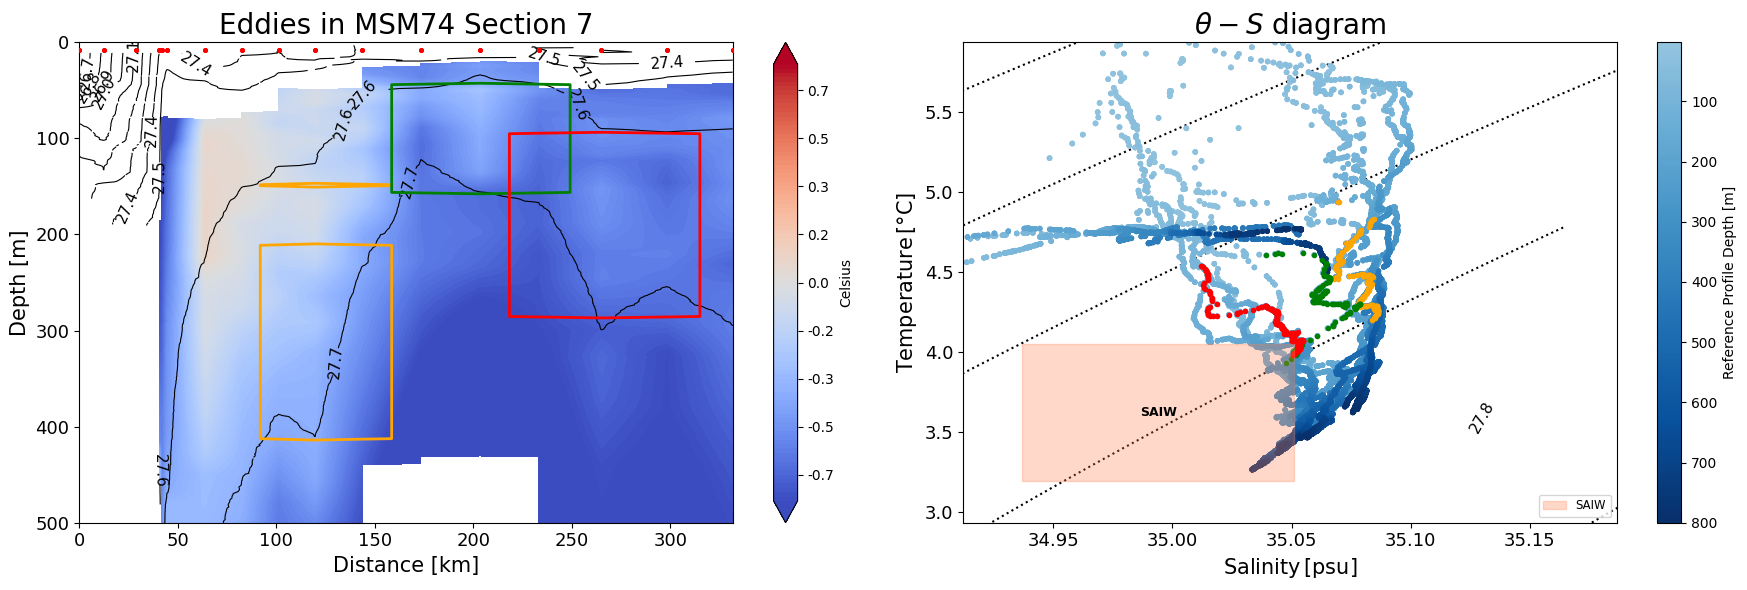

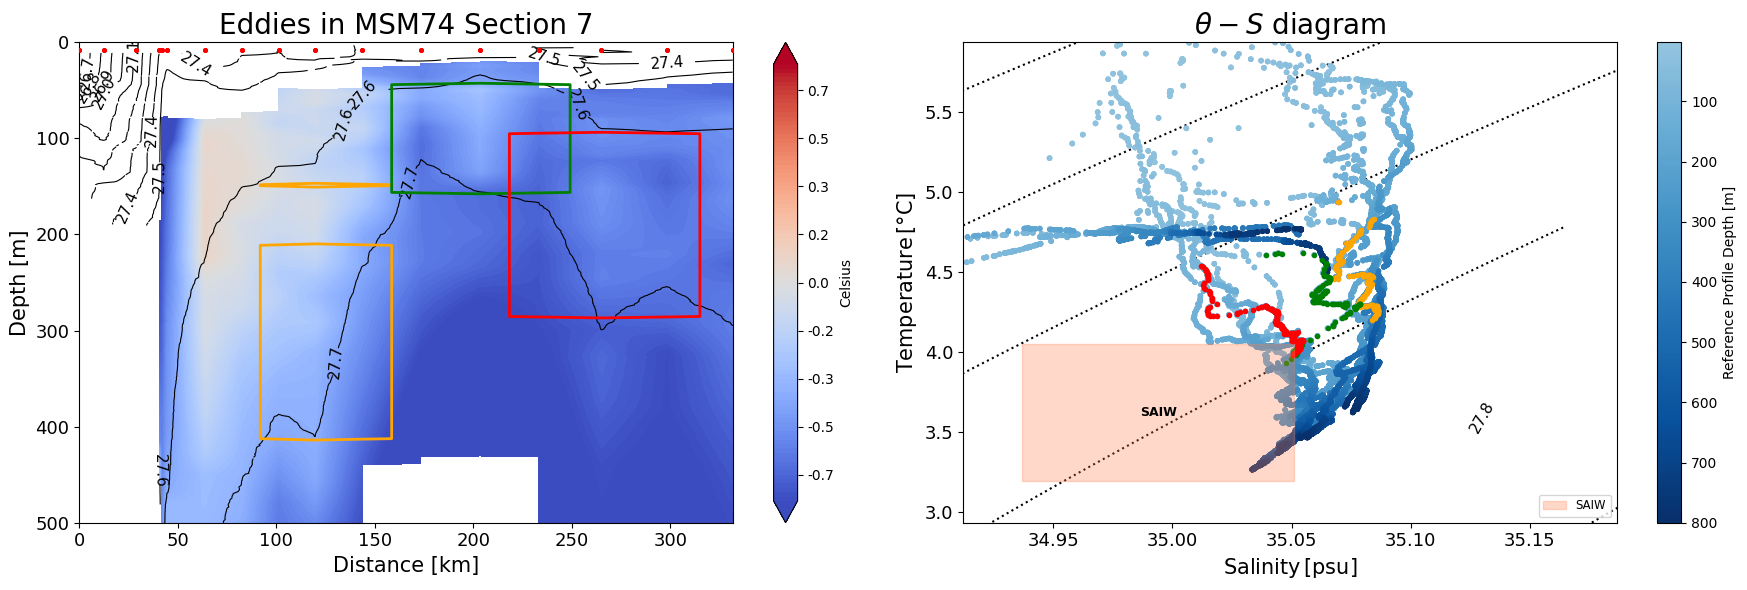

In [ ]:
eddy_lon = []
eddy_lat = []
other_lons = []
other_lats = []
lons = []
lats = []
store_data = {}
# cruises = ["MSM40", "MSM74"]
cruise_map = {"MSM74": [2, 3, 5, 7], "MSM40": [1, 3, 4, 5, 7]}
cruises = ["MSM74"]
cruise_map = {"MSM74": [7], "MSM40": [1, 3, 4, 5, 7]}
subsection_map = {5: [2, 1], 7: [3, 2, 1]}
eddy_num = 1
for cruise in cruises:
    print(f"CRUISE IS: {cruise}")
    sections = cruise_map[cruise]
    set_maxdepth(cruise)
    for section_num in sections:
        print(f"SECTION NUMBER: {section_num}")
        if cruise == "MSM40":
            if section_num in subsection_map.keys():
                sub_sections = subsection_map[section_num]
            else:
                sub_sections = [""]

        else:
            sub_sections = [""]
        for sub_section in sub_sections:
            

            if cruise == "MSM74":
                times, press, depth, T, S, lon, lat, inv_x, lat_adcp_section, lon_adcp_section, depth_adcp, u_adcp, v_adcp = load_data(section_num, lonlatev, ds_ctd, ds_adcp)
                distance = determine_distance(lon, lat, inv_x, section_num)
                
                distance_adcp = determine_distance(lon_adcp_section, lat_adcp_section, inv_x, section_num)
                v_ortho = calc_ortho_vel(section_num, cruise, lon_adcp_section, lat_adcp_section, u_adcp, v_adcp)
                mdepth = get_maxdepth()
                distance, depth, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat = snip_data(distance, depth, section_num, v_ortho, lon_adcp_section, lat_adcp_section, distance_adcp, times, press, depth, T, S, lon, lat)
                if section_num == 1:
                    distance_adcp = np.linspace(np.min(distance), np.max(distance), len(distance_adcp))

                sigma0 = determine_sigma(S, T, press, lon, lat)
                SA = gsw.SA_from_SP(S, press, lon, lat)  # Longitude and Latitude needed
                CT = gsw.CT_from_t(SA, T, press)
                mdepth = get_maxdepth()
                ndepth = get_numdepth()

                CT = make_3D(distance, depth, CT, section_num, cruise)
                SA = make_3D(distance, depth, SA, section_num, cruise)
                sigma_grid = make_3D(distance, depth, sigma0, section_num, cruise)

                print(f"Conservative Temperature shape: {CT.shape}")


                if section_num == 5:
                    indices = find_increasing_intervals(depth)
                    xs = np.array([distance[s] for s, st in indices])
                    print(len(xs))
                else:
                    xs = np.unique(distance)
                    
                print(mdepth)
                depth = np.linspace(0, mdepth, ndepth)
                zs = depth
                distance = xs
                lats_unique = np.unique(lat)
                lons_unique = np.unique(lon)
                yl = 800

                
            if cruise=="MSM40":
                # Define the section (section 2 can't be plotted => no uCTD measures)
                start_index, end_index, len_section, start_index_adcp, end_index_adcp = f.section(section_num)
                name = f'section_{section_num}'
                inv_x = 0
                
                # Define depth limit for uCTD
                depth_max=300

                # Define depth limit for ADCP
                depth_max_adcp=300

                # Create depth array
                depth = np.arange(0, 1001)

                # CTD data
                lon = np.squeeze(uCTD['uctdlon'])[start_index:end_index+1]
                lat = np.squeeze(uCTD['uctdlat'])[start_index:end_index+1]
                T = np.squeeze(uCTD['Tgrid'])[:,start_index:end_index+1]
                PD = np.squeeze(uCTD['PDgrid'])[:,start_index:end_index+1]
                S = np.squeeze(uCTD['Sgrid'])[:,start_index:end_index+1]
                press = uCTD['pressure']
                

                # Select adcp data
                b = adcp['b']
                bb = b[0,0]
                ref = bb[0][0,0][0]
                nav = bb[2][0,0][0]
                vel = bb[1]
                u = vel[:,0,:] + ref[0,:] # vitesse zonale, positive vers l'est
                v = vel[:,1,:] + ref[1,:] # vitesse méridionale, positive vers le nord
                depth_adcp = bb[3][0]
                LON_adcp = nav[1,:]
                LAT_adcp = nav[2,:]
                LAT = LAT_adcp[start_index_adcp:end_index_adcp+1]
                LON = LON_adcp[start_index_adcp:end_index_adcp+1]
                u_section = u[:,start_index_adcp:end_index_adcp+1]
                v_section = v[:,start_index_adcp:end_index_adcp+1]

                if section_num == 5:
                    splits = [-45.168683, -53.5, -60.0843339]
                    start = splits[sub_section - 1]
                    stop = splits[sub_section]
                    valid_ctd = np.where(np.logical_and(lon < start, lon > stop))
                    lon = lon[valid_ctd]
                    lat = lat[valid_ctd]
                    T = T[:, valid_ctd].squeeze()
                    PD = PD[:, valid_ctd].squeeze()
                    S = S[:, valid_ctd].squeeze()
                    valid_adcp = np.where(np.logical_and(LON < start, LON > stop))
                    LAT = LAT[valid_adcp]
                    LON = LON[valid_adcp]
                    u_section = u_section[:, valid_adcp].squeeze()
                    v_section = v_section[:, valid_adcp].squeeze() 

                if section_num == 7:
                    splits = np.linspace(np.max(lon), np.min(lon), 4)
                    start = splits[sub_section - 1]
                    stop = splits[sub_section]
                    valid_ctd = np.where(np.logical_and(lon < start, lon > stop))
                    lon = lon[valid_ctd]
                    lat = lat[valid_ctd]
                    T = T[:, valid_ctd].squeeze()
                    PD = PD[:, valid_ctd].squeeze()
                    S = S[:, valid_ctd].squeeze()
                    valid_adcp = np.where(np.logical_and(LON < start, LON > stop))
                    LAT = LAT[valid_adcp]
                    LON = LON[valid_adcp]
                    u_section = u_section[:, valid_adcp].squeeze()
                    v_section = v_section[:, valid_adcp].squeeze()

                d1 = np.sin(lat*(math.pi/180))*np.sin(lat[0]*(math.pi/180))
                d2 = np.cos(lat*(math.pi/180))*np.cos(lat[0]*(math.pi/180)) * \
                    np.cos(abs(lon[0]-lon)*(math.pi/180))
                distance = 6371*np.arccos(d1+d2)

                d1_adcp = np.sin(LAT*(math.pi/180))*np.sin(LAT[0]*(math.pi/180))
                d2_adcp = np.cos(LAT*(math.pi/180))*np.cos(LAT[0]*(math.pi/180)) * \
                    np.cos(abs(LON[0]-LON)*(math.pi/180))
                distance_adcp = 6371*np.arccos(d1_adcp+d2_adcp)

                v_ortho = calc_ortho_vel(section_num, cruise, LON, LAT, u_section, v_section)
                mdepth = get_maxdepth()
                ndepth = get_numdepth()

                sigma_grid = PD
                s_grid = S
                t_grid = T

                SA = gsw.SA_from_SP(S, press, lon, lat)  # Longitude and Latitude needed
                CT = gsw.CT_from_t(SA, T, press)

                xs = distance
                zs = depth
                yl = 300
                lons_unique = np.unique(lon)
                lats_unique = np.unique(lat)
    

            tref, sref, lon_sel, lat_sel, depth_ref = get_reference_profile(cruise, section_num, ds, dss, lon, lat, CT, SA, distance, depth)

            anomalyt, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "temperature")
            anomalys, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "salinity")
            anomalyp, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "density")
            
            eddy_dict = get_eddies(section_num, cruise, sub_section=sub_section)
            valid_indices_all = []
            print(f"Anomalyt size: {anomalyt.shape}")
            print(f"ind_Z shape: {ind_Z.shape}")
            for e in eddy_dict:
                eddy_center_x, eddy_center_z, a, b = eddy_dict[e]
                temp_eddy_3d, temp_eddy, sal_eddy, dens_eddy, zs_eddy, temp_other, sal_other, dens_other, zs_other = extract_eddy_data_anom(anomalyt, CT, SA, sigma_grid, xs, ind_Z, (eddy_center_x , eddy_center_z), a, b, cruise=cruise, section_num=section_num, e=e, sub_section=sub_section)
                plot_ts_diagrams_anom_all_eddies(anomalyt, anomalys, xs, zs, CT, SA, sigma_grid, distance, depth, ind_Z, cruise, section_num, sub_section=sub_section)
                store_data[eddy_num] = (sal_eddy, temp_eddy, zs_eddy, sal_other, temp_other, zs_other)
                eddy_num += 1
                valid_indices = np.where(np.any(~np.isnan(temp_eddy_3d), axis=0))[0]
                valid_indices_all.append(valid_indices)

                if cruise == "MSM40":
                    eddy_lon.append(lons_unique[::-1][valid_indices])
                else:
                    eddy_lon.append(lons_unique[valid_indices])

                eddy_lat.append(lats_unique[valid_indices])

            other_indices = np.setdiff1d(np.arange(len(lons_unique)), valid_indices)
            if cruise == "MSM40":
                other_lons.append(lons_unique[::-1][other_indices])
            else:
                other_lons.append(lons_unique[other_indices])
                
            other_lats.append(lats_unique[other_indices])

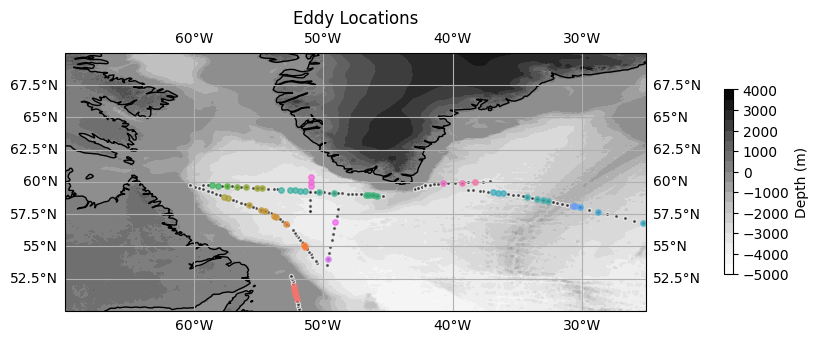

In [18]:

plot_coords_eddies(eddy_lon, eddy_lat, other_lons, other_lats, bathymetry)


/var/folders/08/g_gjz7kj0db8g7wf0vbs2mjw0000gn/T/ipykernel_37200/1507179138.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(sal_eddy, temp_eddy, c=eddy_colors[eddy_num-1], marker='.', s=15, zorder=10)  # Intérieur (core of the eddy in red)
/var/folders/08/g_gjz7kj0db8g7wf0vbs2mjw0000gn/T/ipykernel_37200/1507179138.py:83: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for path in CS.collections[np.where(density_levels == closest_level)[0][0]].get_paths():


(-2.0, 15.0)

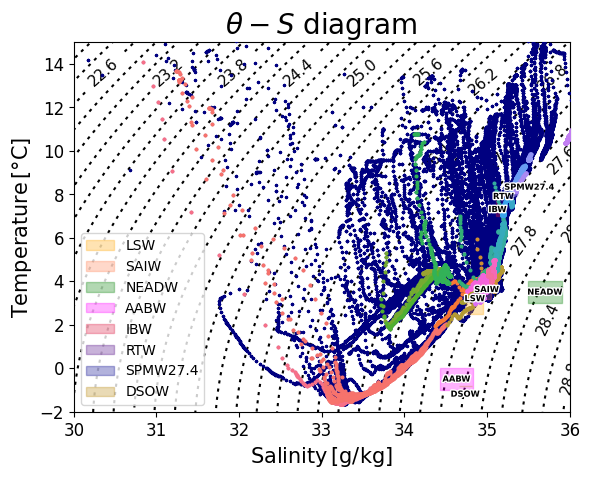

In [8]:
fig, ax2 = plt.subplots()
SAL_diag = np.arange(30, 37, 0.1)
TEMP_diag = np.arange(-3, 20, 0.1)
SAL_diag, TEMP_diag = np.meshgrid(SAL_diag, TEMP_diag)
SIGMA0_diag = gsw.density.sigma0(SAL_diag, TEMP_diag)
Contourrange = np.arange(21, 38, 0.2)

CS = ax2.contour(SAL_diag, TEMP_diag, SIGMA0_diag, Contourrange, colors='k', linestyles=':', zorder=1)

ax2.clabel(CS, fontsize=11, manual=False)

num_eddies = len(eddy_lon)
eddy_colors = sns.color_palette("husl", num_eddies)  # Distinct colors

for eddy_num in store_data:
    sal_eddy, temp_eddy, zs_eddy, sal_other, temp_other, zs_other = store_data[eddy_num]
    ax2.scatter(sal_eddy, temp_eddy, c=eddy_colors[eddy_num-1], marker='.', s=15, zorder=10)  # Intérieur (core of the eddy in red)
    ax2.scatter(sal_other, temp_other, c="navy", marker='.', s=8, zorder=5)

water_masses = {
    "LSW" : (3.2, 0.7, 34.85, 0.1, 'orange'),
    "SAIW": (3.62, 0.43, 34.994, 0.057, 'coral'),
    # "MW" : (12, 0.5, 36.3, 0.2, 'darkgreen'),
    "NEADW" : (3.5, 0.5, 35.7, 0.2, 'green'),
    "AABW" : (-0.5, 0.5, 34.63, 0.2, 'magenta'),
    # "EDW": (18, 0.5, 36.5, 0.2, 'darkcyan'),
    "IBW": (7.5, 0.5, 35.125, 0.02, 'crimson'),
    "RTW": (7.7, 0.3, 35.2, 0.02, 'indigo'),
}

dens_water_masses = {
    "SPMW27.3" : (9.82, 0.8, 35.41, 0.083, 27.3, 0.05, 'darkblue'),
    "SPMW27.4" : (8.64, 0.8, 35.29, 0.04, 27.4, 0.05, 'darkblue'),
    "SPMW27.5" : (7.53, 0.5, 35.2, 0.09, 27.5, 0.05, 'darkblue'),
    "DSOW" : (0.17, 1, 34.66, 0.08, 27.82, 0.05, 'darkgoldenrod'),
    "AAIW" : (4, 0.5, 34.2, 0.1, 27.1, 0.05, 'blue'),
    "ISOW" : (1.25, 1.75, 34.885, 0.015, 27.9, 0.1, 'purple'),
    # "ISW": (3.4, 0.2, 35.02, 0.1, 27.74, 0.05, 'lightpink')
}

if section_num == 4 and cruise == 'MSM40':
    water_masses["S4"] = (3.604, 1.680, 33.934, 0.709, 'darkgreen')

sal_min = float("inf")
sal_max = float("-inf")
temp_min = float("inf")
temp_max = float("-inf")

for eddy_num, (sal_eddy, temp_eddy, _, _, _, _) in store_data.items():
    sal_min = min(sal_min, np.nanmin(sal_eddy))
    sal_max = max(sal_max, np.nanmax(sal_eddy))
    temp_min = min(temp_min, np.nanmin(temp_eddy))
    temp_max = max(temp_max, np.nanmax(temp_eddy))


ymin = temp_min - 1
ymax = temp_max + 1
xmin = sal_min - 0.1
xmax = sal_max + 0.1
shift_map = {"DSOW": (-0.6, 0), "SPMW27.4": (0.2, 0.2), "RTW": (0.2, 0), "IBW": (-0.2, 0)}
for name, (temp_mean, temp_std, sal_mean, sal_std, color) in water_masses.items():
    if np.nanmin(temp_mean) > ymin and np.nanmax(temp_mean) < ymax and np.nanmin(sal_mean) > xmin and np.nanmax(sal_mean) < xmax:
        ax2.fill_betweenx(
            [temp_mean - temp_std, temp_mean + temp_std],
            sal_mean - sal_std, sal_mean + sal_std,
            color=color, alpha=0.3, label=name, zorder=8
        )
        if name in shift_map.keys():
            vert_shift, horiz_shift = shift_map[name]
        else:
            vert_shift, horiz_shift = 0, 0
        ax2.text(sal_mean + horiz_shift, temp_mean + vert_shift, name, fontsize=6, ha='center', va='center', color='black', fontweight='bold', zorder=10, path_effects=[path_effects.withStroke(linewidth=2, foreground="white")])


# Highlight only the specific regions along density contours for dens_water_masses
for name, (temp_mean, temp_std, sal_mean, sal_std, density, density_std, color) in dens_water_masses.items():
# Find the closest contour level to the given density
    if np.nanmin(temp_mean) > ymin and np.nanmax(temp_mean) < ymax and np.nanmin(sal_mean) > xmin and np.nanmax(sal_mean) < xmax:
        density_levels = np.array(CS.levels)  # Extract contour levels
        closest_level = density_levels[np.abs(density_levels - density).argmin()]  # Find closest contour

        # Get contour paths corresponding to the closest density level
        for path in CS.collections[np.where(density_levels == closest_level)[0][0]].get_paths():
            vertices = path.vertices
            salinity_contour, temperature_contour = vertices[:, 0], vertices[:, 1]

            # Find the part of the contour that is within the salinity and temperature range
            mask = (
                (temperature_contour >= temp_mean - temp_std) & (temperature_contour <= temp_mean + temp_std) &
                (salinity_contour >= sal_mean - sal_std) & (salinity_contour <= sal_mean + sal_std)
            )

            # Highlight only the selected part of the contour
            if np.any(mask):
                ax2.fill_betweenx(
                    temperature_contour[mask],
                    salinity_contour[mask] - sal_std,
                    salinity_contour[mask] + sal_std,
                    color=color, alpha=0.3, label=name, zorder=10
                )

                # Compute the midpoint for better label placement
                avg_sal = np.mean(salinity_contour[mask])
                avg_temp = np.mean(temperature_contour[mask])
                if name in shift_map.keys():
                    vert_shift, horiz_shift = shift_map[name]
                else:
                    vert_shift, horiz_shift = 0, 0
                # Place the label slightly above the highlighted region
                ax2.text(
                    avg_sal + horiz_shift , avg_temp + vert_shift,  # Shift label slightly upwards
                    name, fontsize=6, ha='center', va='bottom', color='black', fontweight='bold', zorder=10, path_effects=[path_effects.withStroke(linewidth=2, foreground="white")]
                )
ax2.legend(loc='lower left')
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel(r'$ {\rm Salinity \,  [g/kg]}$', fontsize=15, rasterized=True)
ax2.set_ylabel(r'$ {\rm Temperature \,  [} {\rm °C]}$', fontsize=15, rasterized=True)
ax2.set_title(r'$\theta-S$ diagram', fontsize=20)
ax2.set_xlim(30, 36)
ax2.set_ylim(-2, 15)

In [9]:
# other_lons = other_lons[:3]
# other_lats = other_lats[:3]

